In [170]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#Imports
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
register_matplotlib_converters()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from random import gauss as gs
import datetime

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

#Supress default INFO logging
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)

In [171]:
df = pd.read_csv('rollingsales_queens.xls_prepped_bare.csv')

In [172]:
df.reset_index(drop=True)

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
0,4,11434,4121000,2020-07-16
1,1,11370,584569,2020-08-28
2,1,11370,800000,2021-01-11
3,1,11691,300000,2020-12-16
4,1,11691,360000,2020-06-23
...,...,...,...,...
13166,4,11377,254563,2020-12-31
13167,4,11377,254563,2020-12-31
13168,4,11377,1000000,2020-07-10
13169,4,11377,960000,2020-07-01


In [173]:
df.sort_values('SALE DATE')

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
11776,1,11434,434500,2020-04-01
5303,2,11375,1150000,2020-04-01
10406,4,11418,2500000,2020-04-01
11814,1,11434,358000,2020-04-01
12658,1,11357,720000,2020-04-01
...,...,...,...,...
13114,2,11377,370000,2021-03-31
10094,1,11418,773800,2021-03-31
5566,2,11004,167600,2021-03-31
5156,2,11375,425000,2021-03-31


In [174]:
df[df['SALE DATE'] == '2020-04-01']

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
421,2,11102,650000,2020-04-01
1706,1,11411,615000,2020-04-01
2349,1,11369,535000,2020-04-01
3821,2,11355,182000,2020-04-01
5303,2,11375,1150000,2020-04-01
5450,1,11365,760000,2020-04-01
5921,2A,11385,1880000,2020-04-01
6999,2,11372,427500,2020-04-01
7320,1,11415,899000,2020-04-01
8783,1,11379,675000,2020-04-01


In [175]:
df[df['SALE DATE'] == '2020-04-04']

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE


In [176]:
df['SALE DATE']= pd.to_datetime(df['SALE DATE'])
df=df.sort_values(by='SALE DATE')

In [108]:
type(df['SALE DATE'][2])

pandas._libs.tslibs.timestamps.Timestamp

In [152]:
df_price_date = pd.DataFrame(df, columns=['SALE DATE', 'SALE PRICE'])

In [153]:
df_price_date = df_price_date.set_index('SALE DATE')

In [154]:
df_price_date['SALE PRICE'].isnull().sum()

0

In [155]:
#We see here that there are 295 unique values in terms of the dates that are attached to prices. There are 70 days which are
#not present. 
df_price_date.index.unique()

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-06',
               '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
               '2020-04-12', '2020-04-13',
               ...
               '2021-03-19', '2021-03-21', '2021-03-22', '2021-03-23',
               '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='SALE DATE', length=295, freq=None)

In [156]:
df_price_date

,SALE PRICE
SALE DATE,
2020-04-01,434500
2020-04-01,1150000
2020-04-01,2500000
2020-04-01,358000
2020-04-01,720000
...,...
2021-03-31,370000
2021-03-31,773800
2021-03-31,167600


In [114]:
# df_price_date.index.unique

In [177]:
#group by day
df_price_date = df_price_date.resample('D').mean()

In [178]:
#Here we see that since we resampled by day, there are NaN values for the days that there were no sales due to no sale date, pandas autofilled it with NaN
df_price_date['SALE PRICE'].isna()

SALE DATE
2020-04-01    False
2020-04-02    False
2020-04-03    False
2020-04-04     True
2020-04-05     True
              ...  
2021-03-27     True
2021-03-28     True
2021-03-29    False
2021-03-30    False
2021-03-31    False
Freq: D, Name: SALE PRICE, Length: 365, dtype: bool

In [180]:
#The values that did not have any sale days where showing up as NaN, so instead I filled it with 0 values.
df_price_date['SALE PRICE']=df_price_date['SALE PRICE'].fillna(0)

In [161]:
df_price_date.dropna(inplace=True)

In [162]:
df_price_date.dropna(inplace=True)

In [187]:
#I just get rid of all the 0 values and Nan values for a total of 70 dates gone and then proceed with the decomposition and arma modeling

df_price_date.loc[(df_price_date!=0).any(1)]

,SALE PRICE
SALE DATE,
2020-04-01,961150.000000
2020-04-02,753357.142857
2020-04-03,681724.206897
2020-04-06,725208.000000
2020-04-07,630053.736842
...,...
2021-03-25,609609.756098
2021-03-26,652589.285714
2021-03-29,694114.470588


In [188]:
df_price_date

,SALE PRICE
SALE DATE,
2020-04-01,961150.000000
2020-04-02,753357.142857
2020-04-03,681724.206897
2020-04-04,0.000000
2020-04-05,0.000000
...,...
2021-03-27,0.000000
2021-03-28,0.000000
2021-03-29,694114.470588


In [121]:
decomposition = seasonal_decompose(df_price_date['SALE PRICE'], model='additive', period=30)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [144]:
df_price_date

,SALE PRICE
SALE DATE,
2020-04-16,961150.000000
2020-04-17,753357.142857
2020-04-20,681724.206897
2020-04-21,725208.000000
2020-04-22,630053.736842
...,...
2021-03-25,687746.140625
2021-03-26,679635.985294
2021-03-29,475000.000000


In [122]:
register_matplotlib_converters()

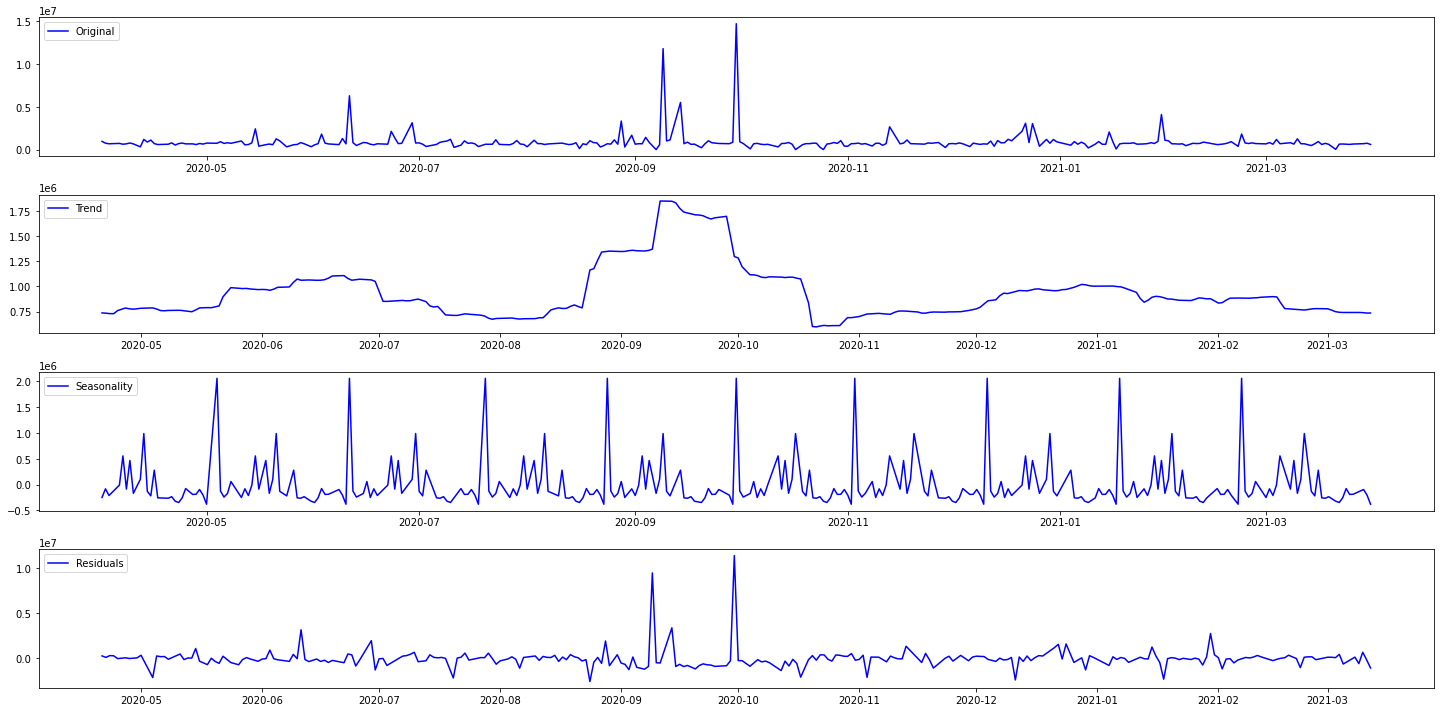

In [123]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

In [124]:
# df_price_date['roll_avg'] = df_price_date['SALE PRICE'].rolling(window=5).mean()

In [125]:
# df_price_date

In [126]:
# plt.figure(figsize=(20, 10))
# plt.scatter(df_price_date.index[:365], df_price_date['SALE PRICE'][:365], s=20)
# plt.scatter(df_price_date.index[4:365], df_price_date['roll_avg'][4:365], s=20);

In [127]:
# lr = LinearRegression()
# lr.fit(df_price_date[['roll_avg']][4:], df_price_date['SALE PRICE'][4:])

In [128]:
# plt.figure(figsize=(20, 10))
# plt.plot(df_price_date.index[:265], df_price_date['SALE PRICE'][:265], label='Data')
# plt.plot(df_price_date.index[4:265], lr.predict(df_price_date[['roll_avg']][4:265]),
#          label='Predicted')
# plt.legend();

In [194]:
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-8.565541911900292, 8.466399684197556e-14, 4, 360, {'1%': -3.448645946352023, '5%': -2.869602139060357, '10%': -2.5710650077160495}, 10680.436655510479)

Test Statistic                -8.565542e+00
p-value                        8.466400e-14
#Lags Used                     4.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (1%)           -3.448646e+00
Critical Value (5%)           -2.869602e+00
Critical Value (10%)          -2.571065e+00
dtype: float64


In [195]:
#differencing to remove seasonality period 12 rolling mean
df_price_date_diff= df_price_date.diff(periods=12)
df_price_date_diff.dropna(inplace=True)
df_price_date_diff.reset_index(drop=True)


,SALE PRICE
0,231813.434783
1,130526.357143
2,433924.859770
3,703075.894737
4,593240.800000
...,...
348,-684445.933333
349,-943197.769231
350,93707.211968
351,12246.143031


In [196]:
df_price_date = df_price_date - df_price_date_diff

In [197]:
df_price_date.dropna(inplace=True)

In [198]:
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-8.459627641669952, 1.5801689255180333e-13, 4, 348, {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}, 10321.579392840436)

Test Statistic                -8.459628e+00
p-value                        1.580169e-13
#Lags Used                     4.000000e+00
Number of Observations Used    3.480000e+02
Critical Value (1%)           -3.449282e+00
Critical Value (5%)           -2.869881e+00
Critical Value (10%)          -2.571214e+00
dtype: float64


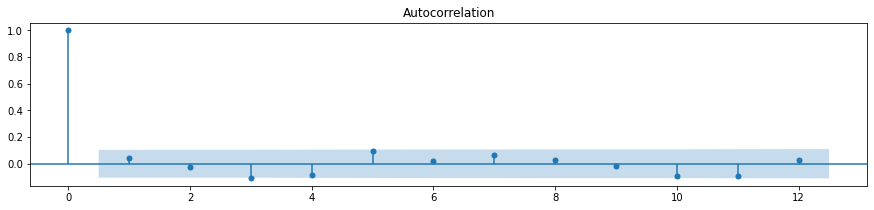

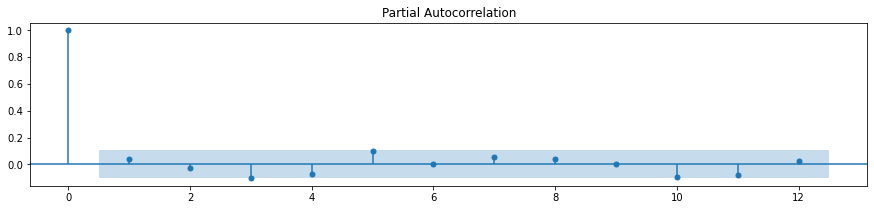

In [199]:
rcParams['figure.figsize'] = 15, 3
plot_acf(df_price_date, lags=12, alpha=0.05);

rcParams['figure.figsize'] = 15, 3
plot_pacf(df_price_date, lags=12, alpha=0.05);

In [200]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
#about 2/3 of the way between 25 and 50, 2/3 of 25 is roughly 17. Ill say 25 + 17 = 42
p = 5

 # q = lagged forecast errors - PACF
    
q = 5


# Fitting ARMA model and summary
ar = ARMA(df_price_date,(p, q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             SALE PRICE   No. Observations:                  353
Model:                     ARMA(5, 5)   Log Likelihood               -5409.904
Method:                       css-mle   S.D. of innovations        1078132.039
Date:                Thu, 17 Jun 2021   AIC                          10843.808
Time:                        06:21:47   BIC                          10890.206
Sample:                    04-13-2020   HQIC                         10862.270
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              7.43e+05   5.98e+04     12.426      0.000    6.26e+05     8.6e+05
ar.L1.SALE PRICE    -0.9106      0.038    -23.993      0.000      -0.985      -0.836
ar.L2.SALE PRICE    -0.3834      0.026    -14.702      0.000      -0.435      -0.332
ar.L3.SALE PRICE    -0.4637      0.019    -24.969      0.000      -0.500      -0.427
ar.L4.SALE PRICE    -0.9560      0.031    -31.175      0.000      -1.016      -0.896
ar.L5.SALE PRICE    -0.8983      0.031    -28.634      0.000      -0.960      -0.837
ma.L1.SALE PRICE     0.9616      0.026     36.317      0.000       0.910       1.013
ma.L2.SALE PRICE     0.4417      0.031     14.074      0.000       0.380       0.503
ma.L3.SALE PRICE     0.4411      0.035     12.496      0.000       0.372       0.510
ma.L4.SALE PRICE     0.9628      0.046     20.919      0.000       0.873       1.053
ma.L5.SALE PRICE     0.9989      0.032     30.906      0.000       0.936       1.062
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6241           -0.7814j            1.0001           -0.1427
AR.2            0.6241           +0.7814j            1.0001            0.1427
AR.3           -0.6419           -0.8185j            1.0402           -0.3558
AR.4           -0.6419           +0.8185j            1.0402            0.3558
AR.5           -1.0287           -0.0000j            1.0287           -0.5000
MA.1            0.6260           -0.7798j            1.0000           -0.1423
MA.2            0.6260           +0.7798j            1.0000            0.1423
MA.3           -0.6074           -0.7944j            1.0000           -0.3539
MA.4           -0.6074           +0.7944j            1.0000            0.3539
MA.5           -1.0011           -0.0000j            1.0011           -0.5000
-----------------------------------------------------------------------------
"""

In [201]:
r2_score(df_price_date, ar.predict())

0.10605085056277352

In [202]:
df_price_date.index.unique()

DatetimeIndex(['2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
               '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20',
               '2020-04-21', '2020-04-22',
               ...
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='SALE DATE', length=353, freq=None)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

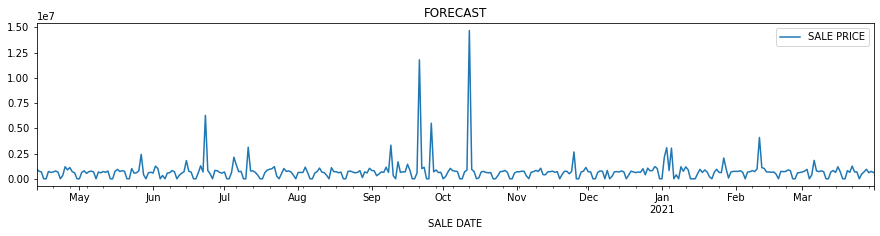

In [203]:
#plot of ARMA model
fig, ax = plt.subplots()
ax = df_price_date.plot(ax=ax, title='FORECAST')
fig = ar.plot_predict('2020-04-01', '2021-06-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()